## Stacking with out of fold predictions


In [1]:
import utils
from utils import *
import xgboost as xgb
import seaborn as sns
%matplotlib inline

/home/ubuntu/anaconda2/envs/qenv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [54]:
xgb_test_preds = load_array("data/results/xgb_5fold_s2019_test_preds_extrasvdv2.dat")
xgb_oof_preds = load_array("data/results/xgb_5fold_s2019_oof_preds_extrasvdv2.dat")

In [55]:
NN_test_preds = load_array("data/results/onedconvs_5fold_s2019_test_preds_extrasvdv2.dat/")
NN_oof_preds = load_array("data/results/onedconvs_5fold_s2019_oof_preds_extrasvdv2.dat/")

In [56]:
NN_val_scores = load_array("data/results/onedconvs_val_scores.dat/")

In [57]:
NN_val_scores

array([ 0.21821387,  0.21644018,  0.22064898,  0.21610097,  0.21622682])

In [6]:
train_features = np.hstack((xgb_oof_preds,NN_oof_preds))
test_features=np.hstack((xgb_test_preds,NN_test_preds))

In [7]:
train_features.shape, test_features.shape

((404290, 2), (2345796, 2))

In [8]:
labels = np.load(open(LABEL_TRAINING_DATA_FILE, 'rb'))

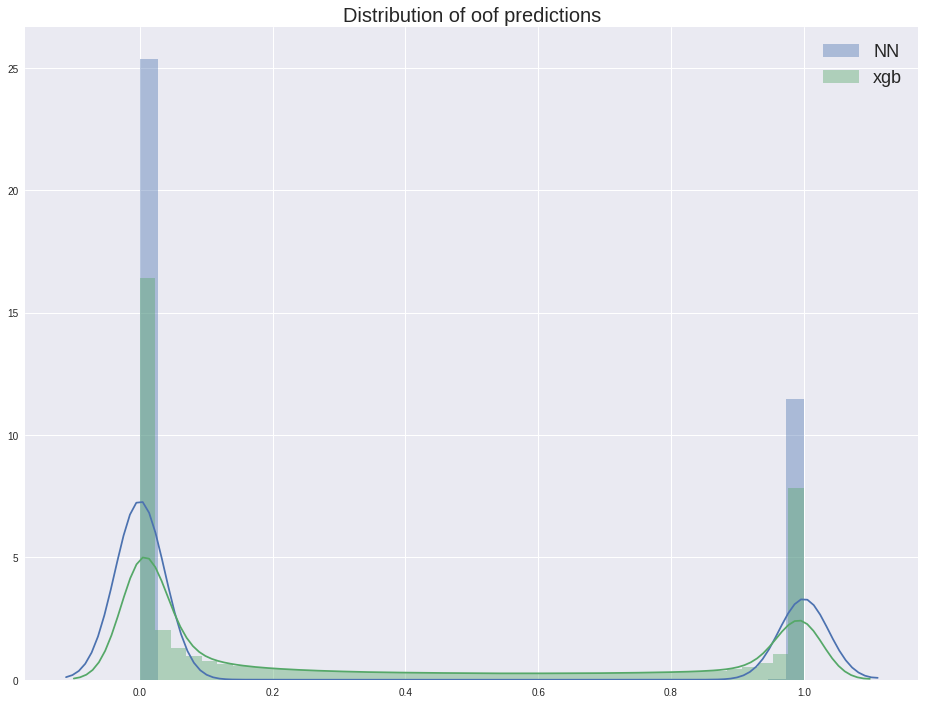

In [9]:
plt.rcParams['figure.figsize'] = 16, 12

sns.distplot(NN_oof_preds,label='NN',), sns.distplot(xgb_oof_preds,label='xgb')
plt.legend(loc='upper right', prop={'size': 18})
plt.title('Distribution of oof predictions', fontsize=20)

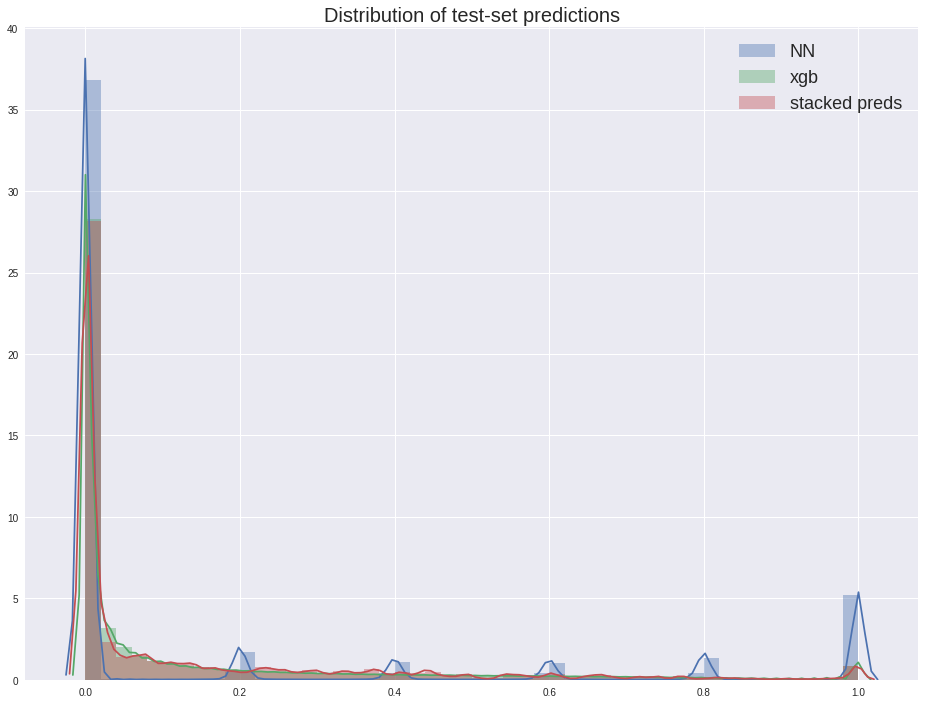

In [29]:
sns.distplot(NN_test_preds,label='NN'), sns.distplot(xgb_test_preds,label='xgb'), sns.distplot(xgb_stacked_preds_raw,label='stacked preds')
plt.legend(loc='upper right', prop={'size': 18})
plt.title('Distribution of test-set predictions', fontsize=20)

In [102]:
preds_avg.max(),xgb_test_preds.max(),NN_test_preds.max()

(0.99973267316818237, 0.99997787475585942, 1.0)

### Model

In [11]:
num_folds = 5
xgb_params = {'colsample_bylevel':1., # 0.9086627943049572,
 'colsample_bytree': 1.,
 'eval_metric': 'logloss',
 'gamma': 1.,#0.02933179779163947,
 'learning_rate': 0.015,#0.028244194429306306,#0.015
 'max_depth': 6,
 'n_estimators': 2500,
 'objective': 'binary:logistic',
 'reg_alpha': 0.0003,#0.14600953461910307,
 'reg_lambda': 2,
 'scale_pos_weight': 1,
 'subsample': 0.9, #0.8097993636153147, 
             'nthread':16,'silent':1}

In [12]:
num_folds = 5 
skf = StratifiedKFold(n_splits=num_folds, random_state=2)
splits = skf.split(train_features, labels)


In [13]:
d_test = xgb.DMatrix(test_features)
preds = np.zeros((test_features.shape[0],1))

for ix_fit, ix_valid in tqdm_notebook(splits, total=num_folds):
    y_val = labels[ix_valid]
    y_train = labels[ix_fit]

                                           
    d_train = xgb.DMatrix(train_features[ix_fit],label= y_train)
    d_valid = xgb.DMatrix(train_features[ix_valid],label= y_val)
    
    
    
    ############## TRAINING
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    bst = xgb.train(xgb_params, d_train, 10000,  watchlist, early_stopping_rounds=50, verbose_eval=10)
    
    
    ################ Test prediction 
    p_test = bst.predict(d_test)
    preds += p_test.reshape(-1,1)
  

[0]	train-logloss:0.682044	valid-logloss:0.681992
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.587016	valid-logloss:0.586587
[20]	train-logloss:0.514338	valid-logloss:0.51368
[30]	train-logloss:0.457449	valid-logloss:0.456661
[40]	train-logloss:0.41218	valid-logloss:0.411335
[50]	train-logloss:0.375722	valid-logloss:0.374856
[60]	train-logloss:0.346082	valid-logloss:0.34523
[70]	train-logloss:0.321815	valid-logloss:0.321005
[80]	train-logloss:0.301832	valid-logloss:0.301086
[90]	train-logloss:0.285303	valid-logloss:0.284625
[100]	train-logloss:0.271588	valid-logloss:0.270986
[110]	train-logloss:0.260172	valid-logloss:0.25965
[120]	train-logloss:0.250648	valid-logloss:0.250203
[130]	train-logloss:0.242682	valid-logloss:0.242315
[140]	train-logloss:0.236015	valid-logloss:0.235724
[150]	train-logloss:0.230431	valid-logloss:0.230213
[160]	train-logloss:0.225749	val

[220]	train-logloss:0.208917	valid-logloss:0.213731
[230]	train-logloss:0.207506	valid-logloss:0.212405
[240]	train-logloss:0.206319	valid-logloss:0.211291
[250]	train-logloss:0.205317	valid-logloss:0.210365
[260]	train-logloss:0.204471	valid-logloss:0.209581
[270]	train-logloss:0.203754	valid-logloss:0.208927
[280]	train-logloss:0.203149	valid-logloss:0.208379
[290]	train-logloss:0.202637	valid-logloss:0.207918
[300]	train-logloss:0.202204	valid-logloss:0.207534
[310]	train-logloss:0.201838	valid-logloss:0.207215
[320]	train-logloss:0.201532	valid-logloss:0.206951
[330]	train-logloss:0.201269	valid-logloss:0.206732
[340]	train-logloss:0.201044	valid-logloss:0.206544
[350]	train-logloss:0.200854	valid-logloss:0.206392
[360]	train-logloss:0.200692	valid-logloss:0.20626
[370]	train-logloss:0.200552	valid-logloss:0.20615
[380]	train-logloss:0.200434	valid-logloss:0.206056
[390]	train-logloss:0.200334	valid-logloss:0.20598
[400]	train-logloss:0.200245	valid-logloss:0.205919
[410]	train-log

[300]	train-logloss:0.20305	valid-logloss:0.204238
[310]	train-logloss:0.202684	valid-logloss:0.203898
[320]	train-logloss:0.202375	valid-logloss:0.203611
[330]	train-logloss:0.202113	valid-logloss:0.203365
[340]	train-logloss:0.20189	valid-logloss:0.203161
[350]	train-logloss:0.2017	valid-logloss:0.202986
[360]	train-logloss:0.201538	valid-logloss:0.202843
[370]	train-logloss:0.2014	valid-logloss:0.202723
[380]	train-logloss:0.201281	valid-logloss:0.20262
[390]	train-logloss:0.201177	valid-logloss:0.202533
[400]	train-logloss:0.201089	valid-logloss:0.202458
[410]	train-logloss:0.201014	valid-logloss:0.202393
[420]	train-logloss:0.200949	valid-logloss:0.202341
[430]	train-logloss:0.200893	valid-logloss:0.202297
[440]	train-logloss:0.200846	valid-logloss:0.202259
[450]	train-logloss:0.200803	valid-logloss:0.202227
[460]	train-logloss:0.200765	valid-logloss:0.2022
[470]	train-logloss:0.200732	valid-logloss:0.202175
[480]	train-logloss:0.200702	valid-logloss:0.202154
[490]	train-logloss:0

In [14]:
bst.best_ntree_limit

720

In [15]:
xgb_stacked_preds_raw = preds / float(num_folds) 

In [16]:
l2_xgb__fixed = link_function(xgb_stacked_preds_raw)

#### level 2 with NN

In [17]:
import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import fbeta_score
from keras.callbacks import ReduceLROnPlateau, EarlyStopping,ModelCheckpoint


from sklearn.preprocessing import StandardScaler
from tqdm import tqdm


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: unknown error)


In [19]:
def NN(num_hidden1,num_hidden2,rate_drop_1,rate_drop_2):

    STAMP = 'NN_%d_%d_%.2f_%.2f'%(num_hidden1, num_hidden2, rate_drop_1, \
            rate_drop_2)


    print STAMP


    layers =  [
        Dense(num_hidden1,activation='relu',input_shape =  (train_features.shape[1],)),
        Dropout(rate_drop_1),   
#         BatchNormalization(),


        Dense(num_hidden2,activation='relu'),
        Dropout(rate_drop_2),   
#         BatchNormalization(),


        Dense(1,activation='sigmoid')]


    return  Sequential(layers), STAMP



In [21]:
test_preds = np.zeros((test_features.shape[0],1))


num_iters = 1
for i in range(num_iters):


    ## create random params for current iteration
    num_hidden1 = np.random.randint(4, 8)
    num_hidden2 = np.random.randint(4, 8)
    rate_drop_1 = 0.1 + np.random.rand() * 0.05
    rate_drop_2 = 0.1 + np.random.rand() * 0.05



    num_folds = 5
    skf = StratifiedKFold(n_splits=num_folds, random_state=17)
    splits = skf.split(train_features, labels)

    for ix_fit, ix_valid in tqdm_notebook(splits, total=num_folds):


        y_val = labels[ix_valid]
        y_train = labels[ix_fit]

        X_train = train_features[ix_fit]
        X_valid = train_features[ix_valid]





        ##### create model
        model,STAMP =NN(num_hidden1,num_hidden2,rate_drop_1,rate_drop_2)


        kfold_weights_path = "weights/stacking_l2_NN_oof_{}.h5".format(STAMP)
        callbacks = [EarlyStopping(monitor='val_loss', patience=4),
                     ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True)]


        model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])



        history = model.fit(x = X_train, y= y_train, validation_data=(X_valid, y_val),
          batch_size=128, epochs=1000,callbacks=callbacks,  shuffle=True,verbose=1)


        ########### prediction

        bst_val_score = min(history.history['val_loss'])
        tqdm.write("bst_val_score:{}".format(bst_val_score) )
        model.load_weights(kfold_weights_path)


        test_preds += model.predict(test_features, batch_size=8192, verbose=1).reshape(-1,1)

test_preds /= float(num_folds)

NN_6_7_0.11_0.14
Train on 323431 samples, validate on 80859 samples
Epoch 1/1000
323431/323431 [==============================] - 1s - loss: 0.7173 - acc: 0.6496 - val_loss: 0.7001 - val_acc: 0.6308
Epoch 2/1000
323431/323431 [==============================] - 1s - loss: 0.6841 - acc: 0.6601 - val_loss: 0.6671 - val_acc: 0.6308
Epoch 3/1000
323431/323431 [==============================] - 1s - loss: 0.6517 - acc: 0.6666 - val_loss: 0.6322 - val_acc: 0.6309
Epoch 4/1000
323431/323431 [==============================] - 1s - loss: 0.6189 - acc: 0.7546 - val_loss: 0.5973 - val_acc: 0.8546
Epoch 5/1000
323431/323431 [==============================] - 1s - loss: 0.5856 - acc: 0.8226 - val_loss: 0.5615 - val_acc: 0.8961
Epoch 6/1000
323431/323431 [==============================] - 1s - loss: 0.5521 - acc: 0.8411 - val_loss: 0.5248 - val_acc: 0.9021
Epoch 7/1000
323431/323431 [==============================] - 1s - loss: 0.5182 - acc: 0.8438 - val_loss: 0.4874 - val_acc: 0.9048
Epoch 8/1000
32

323431/323431 [==============================] - 1s - loss: 0.2681 - acc: 0.9015 - val_loss: 0.2311 - val_acc: 0.9086
Epoch 62/1000
323431/323431 [==============================] - 1s - loss: 0.2687 - acc: 0.9012 - val_loss: 0.2311 - val_acc: 0.9088
Epoch 63/1000
323431/323431 [==============================] - 1s - loss: 0.2680 - acc: 0.9018 - val_loss: 0.2310 - val_acc: 0.9087
Epoch 64/1000
323431/323431 [==============================] - 1s - loss: 0.2676 - acc: 0.9019 - val_loss: 0.2310 - val_acc: 0.9086
Epoch 65/1000
323431/323431 [==============================] - 1s - loss: 0.2678 - acc: 0.9014 - val_loss: 0.2310 - val_acc: 0.9087
Epoch 66/1000
323431/323431 [==============================] - 1s - loss: 0.2679 - acc: 0.9014 - val_loss: 0.2309 - val_acc: 0.9086
Epoch 67/1000
323431/323431 [==============================] - 1s - loss: 0.2673 - acc: 0.9017 - val_loss: 0.2308 - val_acc: 0.9086
Epoch 68/1000
323431/323431 [==============================] - 1s - loss: 0.2668 - acc: 0.

323431/323431 [==============================] - 1s - loss: 0.2570 - acc: 0.9012 - val_loss: 0.2224 - val_acc: 0.9085
Epoch 124/1000
323431/323431 [==============================] - 1s - loss: 0.2560 - acc: 0.9018 - val_loss: 0.2222 - val_acc: 0.9085
Epoch 125/1000
323431/323431 [==============================] - 1s - loss: 0.2561 - acc: 0.9014 - val_loss: 0.2220 - val_acc: 0.9085
Epoch 126/1000
323431/323431 [==============================] - 1s - loss: 0.2559 - acc: 0.9022 - val_loss: 0.2219 - val_acc: 0.9085
Epoch 127/1000
323431/323431 [==============================] - 1s - loss: 0.2558 - acc: 0.9017 - val_loss: 0.2217 - val_acc: 0.9085
Epoch 128/1000
323431/323431 [==============================] - 1s - loss: 0.2555 - acc: 0.9016 - val_loss: 0.2216 - val_acc: 0.9086
Epoch 129/1000
323431/323431 [==============================] - 1s - loss: 0.2554 - acc: 0.9018 - val_loss: 0.2214 - val_acc: 0.9086
Epoch 130/1000
323431/323431 [==============================] - 1s - loss: 0.2552 - 

323431/323431 [==============================] - 1s - loss: 0.2483 - acc: 0.9005 - val_loss: 0.2155 - val_acc: 0.9087
Epoch 185/1000
323431/323431 [==============================] - 1s - loss: 0.2479 - acc: 0.9011 - val_loss: 0.2155 - val_acc: 0.9087
Epoch 186/1000
323431/323431 [==============================] - 1s - loss: 0.2479 - acc: 0.9009 - val_loss: 0.2154 - val_acc: 0.9087
Epoch 187/1000
323431/323431 [==============================] - 1s - loss: 0.2482 - acc: 0.9004 - val_loss: 0.2153 - val_acc: 0.9087
Epoch 188/1000
323431/323431 [==============================] - 1s - loss: 0.2480 - acc: 0.9007 - val_loss: 0.2153 - val_acc: 0.9087
Epoch 189/1000
323431/323431 [==============================] - 1s - loss: 0.2476 - acc: 0.9008 - val_loss: 0.2152 - val_acc: 0.9087
Epoch 190/1000
323431/323431 [==============================] - 1s - loss: 0.2480 - acc: 0.9012 - val_loss: 0.2151 - val_acc: 0.9086
Epoch 191/1000
323431/323431 [==============================] - 1s - loss: 0.2478 - 

323431/323431 [==============================] - 1s - loss: 0.2425 - acc: 0.9017 - val_loss: 0.2125 - val_acc: 0.9084
Epoch 246/1000
323431/323431 [==============================] - 1s - loss: 0.2427 - acc: 0.9014 - val_loss: 0.2124 - val_acc: 0.9084
Epoch 247/1000
323431/323431 [==============================] - 1s - loss: 0.2428 - acc: 0.9014 - val_loss: 0.2124 - val_acc: 0.9084
Epoch 248/1000
323431/323431 [==============================] - 1s - loss: 0.2431 - acc: 0.9010 - val_loss: 0.2123 - val_acc: 0.9084
Epoch 249/1000
323431/323431 [==============================] - 1s - loss: 0.2426 - acc: 0.9017 - val_loss: 0.2123 - val_acc: 0.9084
Epoch 250/1000
323431/323431 [==============================] - 1s - loss: 0.2425 - acc: 0.9018 - val_loss: 0.2122 - val_acc: 0.9084
Epoch 251/1000
323431/323431 [==============================] - 1s - loss: 0.2423 - acc: 0.9016 - val_loss: 0.2122 - val_acc: 0.9084
Epoch 252/1000
323431/323431 [==============================] - 1s - loss: 0.2424 - 

323431/323431 [==============================] - 1s - loss: 0.2384 - acc: 0.9016 - val_loss: 0.2098 - val_acc: 0.9084
Epoch 307/1000
323431/323431 [==============================] - 1s - loss: 0.2385 - acc: 0.9018 - val_loss: 0.2098 - val_acc: 0.9084
Epoch 308/1000
323431/323431 [==============================] - 1s - loss: 0.2387 - acc: 0.9024 - val_loss: 0.2098 - val_acc: 0.9085
Epoch 309/1000
323431/323431 [==============================] - 1s - loss: 0.2387 - acc: 0.9016 - val_loss: 0.2097 - val_acc: 0.9085
Epoch 310/1000
323431/323431 [==============================] - 1s - loss: 0.2383 - acc: 0.9021 - val_loss: 0.2097 - val_acc: 0.9085
Epoch 311/1000
323431/323431 [==============================] - 1s - loss: 0.2383 - acc: 0.9020 - val_loss: 0.2097 - val_acc: 0.9084
Epoch 312/1000
323431/323431 [==============================] - 1s - loss: 0.2381 - acc: 0.9022 - val_loss: 0.2096 - val_acc: 0.9085
Epoch 313/1000
323431/323431 [==============================] - 1s - loss: 0.2383 - 

323431/323431 [==============================] - 1s - loss: 0.2357 - acc: 0.9027 - val_loss: 0.2081 - val_acc: 0.9087
Epoch 368/1000
323431/323431 [==============================] - 1s - loss: 0.2356 - acc: 0.9025 - val_loss: 0.2081 - val_acc: 0.9086
Epoch 369/1000
323431/323431 [==============================] - 1s - loss: 0.2356 - acc: 0.9025 - val_loss: 0.2081 - val_acc: 0.9086
Epoch 370/1000
323431/323431 [==============================] - 1s - loss: 0.2358 - acc: 0.9024 - val_loss: 0.2081 - val_acc: 0.9086
Epoch 371/1000
323431/323431 [==============================] - 1s - loss: 0.2354 - acc: 0.9025 - val_loss: 0.2081 - val_acc: 0.9086
Epoch 372/1000
323431/323431 [==============================] - 1s - loss: 0.2353 - acc: 0.9028 - val_loss: 0.2080 - val_acc: 0.9086
Epoch 373/1000
323431/323431 [==============================] - 1s - loss: 0.2350 - acc: 0.9029 - val_loss: 0.2080 - val_acc: 0.9086
Epoch 374/1000
323431/323431 [==============================] - 1s - loss: 0.2357 - 

323431/323431 [==============================] - 1s - loss: 0.2338 - acc: 0.9026 - val_loss: 0.2073 - val_acc: 0.9082
Epoch 429/1000
323431/323431 [==============================] - 1s - loss: 0.2338 - acc: 0.9024 - val_loss: 0.2073 - val_acc: 0.9082
Epoch 430/1000
323431/323431 [==============================] - 1s - loss: 0.2337 - acc: 0.9029 - val_loss: 0.2072 - val_acc: 0.9082
Epoch 431/1000
323431/323431 [==============================] - 1s - loss: 0.2337 - acc: 0.9029 - val_loss: 0.2072 - val_acc: 0.9082
Epoch 432/1000
323431/323431 [==============================] - 1s - loss: 0.2332 - acc: 0.9027 - val_loss: 0.2072 - val_acc: 0.9082
Epoch 433/1000
323431/323431 [==============================] - 1s - loss: 0.2335 - acc: 0.9030 - val_loss: 0.2072 - val_acc: 0.9082
Epoch 434/1000
323431/323431 [==============================] - 1s - loss: 0.2339 - acc: 0.9028 - val_loss: 0.2072 - val_acc: 0.9082
Epoch 435/1000
323431/323431 [==============================] - 1s - loss: 0.2342 - 

323431/323431 [==============================] - 1s - loss: 0.5848 - acc: 0.6308 - val_loss: 0.5669 - val_acc: 0.6308
Epoch 9/1000
323431/323431 [==============================] - 1s - loss: 0.5614 - acc: 0.6308 - val_loss: 0.5411 - val_acc: 0.6308
Epoch 10/1000
323431/323431 [==============================] - 1s - loss: 0.5371 - acc: 0.6333 - val_loss: 0.5150 - val_acc: 0.6308
Epoch 11/1000
323431/323431 [==============================] - 1s - loss: 0.5135 - acc: 0.6767 - val_loss: 0.4893 - val_acc: 0.7797
Epoch 12/1000
323431/323431 [==============================] - 1s - loss: 0.4902 - acc: 0.7713 - val_loss: 0.4643 - val_acc: 0.8292
Epoch 13/1000
323431/323431 [==============================] - 1s - loss: 0.4681 - acc: 0.7830 - val_loss: 0.4404 - val_acc: 0.8357
Epoch 14/1000
323431/323431 [==============================] - 1s - loss: 0.4470 - acc: 0.8167 - val_loss: 0.4176 - val_acc: 0.8364
Epoch 15/1000
323431/323431 [==============================] - 1s - loss: 0.4267 - acc: 0.8

323431/323431 [==============================] - 1s - loss: 0.2672 - acc: 0.8987 - val_loss: 0.2305 - val_acc: 0.9071
Epoch 71/1000
323431/323431 [==============================] - 1s - loss: 0.2672 - acc: 0.8986 - val_loss: 0.2304 - val_acc: 0.9073
Epoch 72/1000
323431/323431 [==============================] - 1s - loss: 0.2669 - acc: 0.8985 - val_loss: 0.2303 - val_acc: 0.9073
Epoch 73/1000
323431/323431 [==============================] - 1s - loss: 0.2664 - acc: 0.8984 - val_loss: 0.2302 - val_acc: 0.9073
Epoch 74/1000
323431/323431 [==============================] - 1s - loss: 0.2658 - acc: 0.8991 - val_loss: 0.2302 - val_acc: 0.9073
Epoch 75/1000
323431/323431 [==============================] - 1s - loss: 0.2662 - acc: 0.8984 - val_loss: 0.2301 - val_acc: 0.9073
Epoch 76/1000
323431/323431 [==============================] - 1s - loss: 0.2657 - acc: 0.8985 - val_loss: 0.2300 - val_acc: 0.9074
Epoch 77/1000
323431/323431 [==============================] - 1s - loss: 0.2655 - acc: 0.

323431/323431 [==============================] - 1s - loss: 0.2581 - acc: 0.8998 - val_loss: 0.2240 - val_acc: 0.9083
Epoch 132/1000
323431/323431 [==============================] - 1s - loss: 0.2574 - acc: 0.8997 - val_loss: 0.2238 - val_acc: 0.9082
Epoch 133/1000
323431/323431 [==============================] - 1s - loss: 0.2574 - acc: 0.9001 - val_loss: 0.2237 - val_acc: 0.9082
Epoch 134/1000
323431/323431 [==============================] - 1s - loss: 0.2576 - acc: 0.8995 - val_loss: 0.2236 - val_acc: 0.9083
Epoch 135/1000
323431/323431 [==============================] - 1s - loss: 0.2571 - acc: 0.8995 - val_loss: 0.2235 - val_acc: 0.9083
Epoch 136/1000
323431/323431 [==============================] - 1s - loss: 0.2569 - acc: 0.8996 - val_loss: 0.2234 - val_acc: 0.9082
Epoch 137/1000
323431/323431 [==============================] - 1s - loss: 0.2567 - acc: 0.8993 - val_loss: 0.2232 - val_acc: 0.9082
Epoch 138/1000
323431/323431 [==============================] - 1s - loss: 0.2571 - 

323431/323431 [==============================] - 1s - loss: 0.2515 - acc: 0.8991 - val_loss: 0.2177 - val_acc: 0.9084
Epoch 193/1000
323431/323431 [==============================] - 1s - loss: 0.2516 - acc: 0.8991 - val_loss: 0.2176 - val_acc: 0.9085
Epoch 194/1000
323431/323431 [==============================] - 1s - loss: 0.2512 - acc: 0.8991 - val_loss: 0.2175 - val_acc: 0.9085
Epoch 195/1000
323431/323431 [==============================] - 1s - loss: 0.2511 - acc: 0.8994 - val_loss: 0.2175 - val_acc: 0.9084
Epoch 196/1000
323431/323431 [==============================] - 1s - loss: 0.2508 - acc: 0.8991 - val_loss: 0.2174 - val_acc: 0.9083
Epoch 197/1000
323431/323431 [==============================] - 1s - loss: 0.2510 - acc: 0.8994 - val_loss: 0.2173 - val_acc: 0.9084
Epoch 198/1000
323431/323431 [==============================] - 1s - loss: 0.2512 - acc: 0.8987 - val_loss: 0.2172 - val_acc: 0.9085
Epoch 199/1000
323431/323431 [==============================] - 1s - loss: 0.2509 - 

323431/323431 [==============================] - 1s - loss: 0.2474 - acc: 0.8984 - val_loss: 0.2134 - val_acc: 0.9086
Epoch 254/1000
323431/323431 [==============================] - 1s - loss: 0.2480 - acc: 0.8978 - val_loss: 0.2133 - val_acc: 0.9086
Epoch 255/1000
323431/323431 [==============================] - 1s - loss: 0.2477 - acc: 0.8979 - val_loss: 0.2133 - val_acc: 0.9086
Epoch 256/1000
323431/323431 [==============================] - 1s - loss: 0.2482 - acc: 0.8981 - val_loss: 0.2132 - val_acc: 0.9086
Epoch 257/1000
323431/323431 [==============================] - 1s - loss: 0.2478 - acc: 0.8980 - val_loss: 0.2132 - val_acc: 0.9086
Epoch 258/1000
323431/323431 [==============================] - 1s - loss: 0.2478 - acc: 0.8978 - val_loss: 0.2131 - val_acc: 0.9085
Epoch 259/1000
323431/323431 [==============================] - 1s - loss: 0.2481 - acc: 0.8978 - val_loss: 0.2131 - val_acc: 0.9085
Epoch 260/1000
323431/323431 [==============================] - 1s - loss: 0.2471 - 

323431/323431 [==============================] - 1s - loss: 0.2457 - acc: 0.8977 - val_loss: 0.2107 - val_acc: 0.9085
Epoch 315/1000
323431/323431 [==============================] - 1s - loss: 0.2454 - acc: 0.8975 - val_loss: 0.2107 - val_acc: 0.9085
Epoch 316/1000
323431/323431 [==============================] - 1s - loss: 0.2468 - acc: 0.8970 - val_loss: 0.2107 - val_acc: 0.9085
Epoch 317/1000
323431/323431 [==============================] - 1s - loss: 0.2453 - acc: 0.8976 - val_loss: 0.2106 - val_acc: 0.9086
Epoch 318/1000
323431/323431 [==============================] - 1s - loss: 0.2455 - acc: 0.8977 - val_loss: 0.2106 - val_acc: 0.9086
Epoch 319/1000
323431/323431 [==============================] - 1s - loss: 0.2457 - acc: 0.8975 - val_loss: 0.2106 - val_acc: 0.9085
Epoch 320/1000
323431/323431 [==============================] - 1s - loss: 0.2460 - acc: 0.8978 - val_loss: 0.2106 - val_acc: 0.9085
Epoch 321/1000
323431/323431 [==============================] - 1s - loss: 0.2456 - 

323431/323431 [==============================] - 1s - loss: 0.2439 - acc: 0.8979 - val_loss: 0.2094 - val_acc: 0.9084
Epoch 376/1000
323431/323431 [==============================] - 1s - loss: 0.2443 - acc: 0.8972 - val_loss: 0.2094 - val_acc: 0.9084
Epoch 377/1000
323431/323431 [==============================] - 1s - loss: 0.2444 - acc: 0.8978 - val_loss: 0.2093 - val_acc: 0.9084
Epoch 378/1000
323431/323431 [==============================] - 1s - loss: 0.2446 - acc: 0.8976 - val_loss: 0.2093 - val_acc: 0.9084
Epoch 379/1000
323431/323431 [==============================] - 1s - loss: 0.2452 - acc: 0.8972 - val_loss: 0.2093 - val_acc: 0.9084
Epoch 380/1000
323431/323431 [==============================] - 1s - loss: 0.2443 - acc: 0.8978 - val_loss: 0.2093 - val_acc: 0.9084
Epoch 381/1000
323431/323431 [==============================] - 1s - loss: 0.2437 - acc: 0.8981 - val_loss: 0.2093 - val_acc: 0.9084
Epoch 382/1000
323431/323431 [==============================] - 1s - loss: 0.2442 - 

323431/323431 [==============================] - 1s - loss: 0.2425 - acc: 0.8987 - val_loss: 0.2087 - val_acc: 0.9085
Epoch 437/1000
323431/323431 [==============================] - 1s - loss: 0.2431 - acc: 0.8981 - val_loss: 0.2087 - val_acc: 0.9085
Epoch 438/1000
323431/323431 [==============================] - 1s - loss: 0.2423 - acc: 0.8988 - val_loss: 0.2086 - val_acc: 0.9085
Epoch 439/1000
323431/323431 [==============================] - 1s - loss: 0.2428 - acc: 0.8981 - val_loss: 0.2086 - val_acc: 0.9085
Epoch 440/1000
323431/323431 [==============================] - 1s - loss: 0.2428 - acc: 0.8983 - val_loss: 0.2086 - val_acc: 0.9084
Epoch 441/1000
323431/323431 [==============================] - 1s - loss: 0.2426 - acc: 0.8979 - val_loss: 0.2086 - val_acc: 0.9084
Epoch 442/1000
323431/323431 [==============================] - 1s - loss: 0.2428 - acc: 0.8980 - val_loss: 0.2086 - val_acc: 0.9083
Epoch 443/1000
323431/323431 [==============================] - 1s - loss: 0.2428 - 

323431/323431 [==============================] - 1s - loss: 0.2415 - acc: 0.8988 - val_loss: 0.2078 - val_acc: 0.9083
Epoch 498/1000
323431/323431 [==============================] - 1s - loss: 0.2424 - acc: 0.8979 - val_loss: 0.2078 - val_acc: 0.9082
Epoch 499/1000
323431/323431 [==============================] - 1s - loss: 0.2416 - acc: 0.8986 - val_loss: 0.2078 - val_acc: 0.9082
Epoch 500/1000
323431/323431 [==============================] - 1s - loss: 0.2423 - acc: 0.8980 - val_loss: 0.2077 - val_acc: 0.9083
Epoch 501/1000
323431/323431 [==============================] - 1s - loss: 0.2422 - acc: 0.8985 - val_loss: 0.2077 - val_acc: 0.9082
Epoch 502/1000
323431/323431 [==============================] - 1s - loss: 0.2416 - acc: 0.8983 - val_loss: 0.2077 - val_acc: 0.9082
Epoch 503/1000
323431/323431 [==============================] - 1s - loss: 0.2423 - acc: 0.8985 - val_loss: 0.2077 - val_acc: 0.9082
Epoch 504/1000
323431/323431 [==============================] - 1s - loss: 0.2417 - 

323432/323432 [==============================] - 1s - loss: 0.5907 - acc: 0.8049 - val_loss: 0.5366 - val_acc: 0.8683
Epoch 5/1000
323432/323432 [==============================] - 1s - loss: 0.5647 - acc: 0.8077 - val_loss: 0.5070 - val_acc: 0.8683
Epoch 6/1000
323432/323432 [==============================] - 1s - loss: 0.5406 - acc: 0.8084 - val_loss: 0.4800 - val_acc: 0.8683
Epoch 7/1000
323432/323432 [==============================] - 1s - loss: 0.5190 - acc: 0.8086 - val_loss: 0.4560 - val_acc: 0.8683
Epoch 8/1000
323432/323432 [==============================] - 1s - loss: 0.4993 - acc: 0.8088 - val_loss: 0.4345 - val_acc: 0.8683
Epoch 9/1000
323432/323432 [==============================] - 1s - loss: 0.4833 - acc: 0.8093 - val_loss: 0.4157 - val_acc: 0.8684
Epoch 10/1000
323432/323432 [==============================] - 1s - loss: 0.4666 - acc: 0.8103 - val_loss: 0.3984 - val_acc: 0.8684
Epoch 11/1000
323432/323432 [==============================] - 1s - loss: 0.4512 - acc: 0.8115 

323432/323432 [==============================] - 1s - loss: 0.2536 - acc: 0.8975 - val_loss: 0.2298 - val_acc: 0.9056
Epoch 67/1000
323432/323432 [==============================] - 1s - loss: 0.2539 - acc: 0.8978 - val_loss: 0.2295 - val_acc: 0.9059
Epoch 68/1000
323432/323432 [==============================] - 1s - loss: 0.2531 - acc: 0.8974 - val_loss: 0.2292 - val_acc: 0.9061
Epoch 69/1000
323432/323432 [==============================] - 1s - loss: 0.2525 - acc: 0.8979 - val_loss: 0.2290 - val_acc: 0.9062
Epoch 70/1000
323432/323432 [==============================] - 1s - loss: 0.2527 - acc: 0.8990 - val_loss: 0.2287 - val_acc: 0.9064
Epoch 71/1000
323432/323432 [==============================] - 1s - loss: 0.2522 - acc: 0.8993 - val_loss: 0.2284 - val_acc: 0.9065
Epoch 72/1000
323432/323432 [==============================] - 1s - loss: 0.2512 - acc: 0.8989 - val_loss: 0.2281 - val_acc: 0.9066
Epoch 73/1000
323432/323432 [==============================] - 1s - loss: 0.2514 - acc: 0.

323432/323432 [==============================] - 1s - loss: 0.2379 - acc: 0.9028 - val_loss: 0.2206 - val_acc: 0.9083
Epoch 128/1000
323432/323432 [==============================] - 1s - loss: 0.2381 - acc: 0.9028 - val_loss: 0.2204 - val_acc: 0.9083
Epoch 129/1000
323432/323432 [==============================] - 1s - loss: 0.2376 - acc: 0.9029 - val_loss: 0.2203 - val_acc: 0.9083
Epoch 130/1000
323432/323432 [==============================] - 1s - loss: 0.2381 - acc: 0.9023 - val_loss: 0.2202 - val_acc: 0.9083
Epoch 131/1000
323432/323432 [==============================] - 1s - loss: 0.2375 - acc: 0.9028 - val_loss: 0.2201 - val_acc: 0.9082
Epoch 132/1000
323432/323432 [==============================] - 1s - loss: 0.2378 - acc: 0.9032 - val_loss: 0.2200 - val_acc: 0.9082
Epoch 133/1000
323432/323432 [==============================] - 1s - loss: 0.2370 - acc: 0.9030 - val_loss: 0.2198 - val_acc: 0.9082
Epoch 134/1000
323432/323432 [==============================] - 1s - loss: 0.2372 - 

323432/323432 [==============================] - 1s - loss: 0.2315 - acc: 0.9041 - val_loss: 0.2157 - val_acc: 0.9090
Epoch 189/1000
323432/323432 [==============================] - 1s - loss: 0.2315 - acc: 0.9040 - val_loss: 0.2157 - val_acc: 0.9091
Epoch 190/1000
323432/323432 [==============================] - 1s - loss: 0.2310 - acc: 0.9045 - val_loss: 0.2156 - val_acc: 0.9090
Epoch 191/1000
323432/323432 [==============================] - 1s - loss: 0.2317 - acc: 0.9041 - val_loss: 0.2156 - val_acc: 0.9090
Epoch 192/1000
323432/323432 [==============================] - 1s - loss: 0.2316 - acc: 0.9037 - val_loss: 0.2155 - val_acc: 0.9090
Epoch 193/1000
323432/323432 [==============================] - 1s - loss: 0.2316 - acc: 0.9039 - val_loss: 0.2155 - val_acc: 0.9090
Epoch 194/1000
323432/323432 [==============================] - 1s - loss: 0.2312 - acc: 0.9042 - val_loss: 0.2154 - val_acc: 0.9090
Epoch 195/1000
323432/323432 [==============================] - 1s - loss: 0.2310 - 

323432/323432 [==============================] - 1s - loss: 0.2287 - acc: 0.9041 - val_loss: 0.2135 - val_acc: 0.9090
Epoch 250/1000
323432/323432 [==============================] - 1s - loss: 0.2290 - acc: 0.9045 - val_loss: 0.2135 - val_acc: 0.9091
Epoch 251/1000
323432/323432 [==============================] - 1s - loss: 0.2286 - acc: 0.9043 - val_loss: 0.2135 - val_acc: 0.9090
Epoch 252/1000
323432/323432 [==============================] - 1s - loss: 0.2282 - acc: 0.9047 - val_loss: 0.2135 - val_acc: 0.9090
Epoch 253/1000
323432/323432 [==============================] - 1s - loss: 0.2283 - acc: 0.9045 - val_loss: 0.2134 - val_acc: 0.9090
Epoch 254/1000
323432/323432 [==============================] - 1s - loss: 0.2285 - acc: 0.9045 - val_loss: 0.2134 - val_acc: 0.9090
Epoch 255/1000
323432/323432 [==============================] - 1s - loss: 0.2285 - acc: 0.9045 - val_loss: 0.2134 - val_acc: 0.9090
Epoch 256/1000
323432/323432 [==============================] - 1s - loss: 0.2286 - 

323432/323432 [==============================] - 1s - loss: 0.2269 - acc: 0.9045 - val_loss: 0.2122 - val_acc: 0.9091
Epoch 311/1000
323432/323432 [==============================] - 1s - loss: 0.2265 - acc: 0.9046 - val_loss: 0.2122 - val_acc: 0.9091
Epoch 312/1000
323432/323432 [==============================] - 1s - loss: 0.2261 - acc: 0.9051 - val_loss: 0.2122 - val_acc: 0.9091
Epoch 313/1000
323432/323432 [==============================] - 1s - loss: 0.2263 - acc: 0.9047 - val_loss: 0.2122 - val_acc: 0.9091
Epoch 314/1000
323432/323432 [==============================] - 1s - loss: 0.2268 - acc: 0.9050 - val_loss: 0.2121 - val_acc: 0.9091
Epoch 315/1000
323432/323432 [==============================] - 1s - loss: 0.2262 - acc: 0.9048 - val_loss: 0.2121 - val_acc: 0.9091
Epoch 316/1000
323432/323432 [==============================] - 1s - loss: 0.2260 - acc: 0.9048 - val_loss: 0.2121 - val_acc: 0.9090
Epoch 317/1000
323432/323432 [==============================] - 1s - loss: 0.2265 - 

323432/323432 [==============================] - 1s - loss: 0.2253 - acc: 0.9064 - val_loss: 0.2111 - val_acc: 0.9090
Epoch 372/1000
323432/323432 [==============================] - 1s - loss: 0.2241 - acc: 0.9063 - val_loss: 0.2111 - val_acc: 0.9090
Epoch 373/1000
323432/323432 [==============================] - 1s - loss: 0.2246 - acc: 0.9059 - val_loss: 0.2111 - val_acc: 0.9090
Epoch 374/1000
323432/323432 [==============================] - 1s - loss: 0.2249 - acc: 0.9061 - val_loss: 0.2111 - val_acc: 0.9090
Epoch 375/1000
323432/323432 [==============================] - 1s - loss: 0.2239 - acc: 0.9063 - val_loss: 0.2111 - val_acc: 0.9090
Epoch 376/1000
323432/323432 [==============================] - 1s - loss: 0.2245 - acc: 0.9065 - val_loss: 0.2110 - val_acc: 0.9089
Epoch 377/1000
323432/323432 [==============================] - 1s - loss: 0.2247 - acc: 0.9059 - val_loss: 0.2110 - val_acc: 0.9090
Epoch 378/1000
323432/323432 [==============================] - 1s - loss: 0.2249 - 

323432/323432 [==============================] - 1s - loss: 0.2228 - acc: 0.9067 - val_loss: 0.2103 - val_acc: 0.9088
Epoch 433/1000
323432/323432 [==============================] - 1s - loss: 0.2229 - acc: 0.9066 - val_loss: 0.2103 - val_acc: 0.9088
Epoch 434/1000
323432/323432 [==============================] - 1s - loss: 0.2228 - acc: 0.9064 - val_loss: 0.2103 - val_acc: 0.9087
Epoch 435/1000
323432/323432 [==============================] - 1s - loss: 0.2228 - acc: 0.9066 - val_loss: 0.2103 - val_acc: 0.9087
Epoch 436/1000
323432/323432 [==============================] - 1s - loss: 0.2231 - acc: 0.9069 - val_loss: 0.2103 - val_acc: 0.9088
Epoch 437/1000
323432/323432 [==============================] - 1s - loss: 0.2235 - acc: 0.9065 - val_loss: 0.2102 - val_acc: 0.9088
Epoch 438/1000
323432/323432 [==============================] - 1s - loss: 0.2227 - acc: 0.9066 - val_loss: 0.2103 - val_acc: 0.9088
Epoch 439/1000
323432/323432 [==============================] - 1s - loss: 0.2228 - 

323432/323432 [==============================] - 1s - loss: 0.2220 - acc: 0.9066 - val_loss: 0.2096 - val_acc: 0.9089
Epoch 494/1000
323432/323432 [==============================] - 1s - loss: 0.2219 - acc: 0.9067 - val_loss: 0.2096 - val_acc: 0.9089
Epoch 495/1000
323432/323432 [==============================] - 1s - loss: 0.2212 - acc: 0.9067 - val_loss: 0.2096 - val_acc: 0.9089
Epoch 496/1000
323432/323432 [==============================] - 1s - loss: 0.2219 - acc: 0.9066 - val_loss: 0.2095 - val_acc: 0.9089
Epoch 497/1000
323432/323432 [==============================] - 1s - loss: 0.2216 - acc: 0.9066 - val_loss: 0.2096 - val_acc: 0.9089
Epoch 498/1000
323432/323432 [==============================] - 1s - loss: 0.2216 - acc: 0.9067 - val_loss: 0.2095 - val_acc: 0.9089
Epoch 499/1000
323432/323432 [==============================] - 1s - loss: 0.2211 - acc: 0.9067 - val_loss: 0.2096 - val_acc: 0.9090
Epoch 500/1000
323432/323432 [==============================] - 1s - loss: 0.2218 - 

323433/323433 [==============================] - 1s - loss: 0.4549 - acc: 0.7987 - val_loss: 0.5109 - val_acc: 0.7548
Epoch 18/1000
323433/323433 [==============================] - 1s - loss: 0.4462 - acc: 0.7992 - val_loss: 0.5016 - val_acc: 0.7548
Epoch 19/1000
323433/323433 [==============================] - 1s - loss: 0.4386 - acc: 0.7992 - val_loss: 0.4924 - val_acc: 0.7548
Epoch 20/1000
323433/323433 [==============================] - 1s - loss: 0.4309 - acc: 0.7987 - val_loss: 0.4830 - val_acc: 0.7548
Epoch 21/1000
323433/323433 [==============================] - 1s - loss: 0.4245 - acc: 0.7994 - val_loss: 0.4733 - val_acc: 0.7548
Epoch 22/1000
323433/323433 [==============================] - 1s - loss: 0.4177 - acc: 0.8009 - val_loss: 0.4623 - val_acc: 0.7548
Epoch 23/1000
323433/323433 [==============================] - 1s - loss: 0.4100 - acc: 0.8042 - val_loss: 0.4511 - val_acc: 0.7548
Epoch 24/1000
323433/323433 [==============================] - 1s - loss: 0.4046 - acc: 0.

323433/323433 [==============================] - 1s - loss: 0.2827 - acc: 0.8901 - val_loss: 0.2394 - val_acc: 0.9081
Epoch 80/1000
323433/323433 [==============================] - 1s - loss: 0.2824 - acc: 0.8900 - val_loss: 0.2391 - val_acc: 0.9081
Epoch 81/1000
323433/323433 [==============================] - 1s - loss: 0.2824 - acc: 0.8899 - val_loss: 0.2389 - val_acc: 0.9082
Epoch 82/1000
323433/323433 [==============================] - 1s - loss: 0.2832 - acc: 0.8892 - val_loss: 0.2388 - val_acc: 0.9082
Epoch 83/1000
323433/323433 [==============================] - 1s - loss: 0.2825 - acc: 0.8898 - val_loss: 0.2386 - val_acc: 0.9083
Epoch 84/1000
323433/323433 [==============================] - 1s - loss: 0.2825 - acc: 0.8898 - val_loss: 0.2384 - val_acc: 0.9084
Epoch 85/1000
323433/323433 [==============================] - 1s - loss: 0.2819 - acc: 0.8897 - val_loss: 0.2383 - val_acc: 0.9084
Epoch 86/1000
323433/323433 [==============================] - 1s - loss: 0.2811 - acc: 0.

323433/323433 [==============================] - 1s - loss: 0.6302 - acc: 0.8289 - val_loss: 0.6161 - val_acc: 0.8738
Epoch 3/1000
323433/323433 [==============================] - 1s - loss: 0.6141 - acc: 0.8406 - val_loss: 0.5985 - val_acc: 0.8821
Epoch 4/1000
323433/323433 [==============================] - 1s - loss: 0.5991 - acc: 0.8459 - val_loss: 0.5816 - val_acc: 0.8862
Epoch 5/1000
323433/323433 [==============================] - 1s - loss: 0.5843 - acc: 0.8500 - val_loss: 0.5649 - val_acc: 0.8892
Epoch 6/1000
323433/323433 [==============================] - 1s - loss: 0.5703 - acc: 0.8529 - val_loss: 0.5485 - val_acc: 0.8916
Epoch 7/1000
323433/323433 [==============================] - 1s - loss: 0.5565 - acc: 0.8554 - val_loss: 0.5327 - val_acc: 0.8930
Epoch 8/1000
323433/323433 [==============================] - 1s - loss: 0.5432 - acc: 0.8573 - val_loss: 0.5175 - val_acc: 0.8941
Epoch 9/1000
323433/323433 [==============================] - 1s - loss: 0.5293 - acc: 0.8632 - 

323433/323433 [==============================] - 1s - loss: 0.2621 - acc: 0.9029 - val_loss: 0.2318 - val_acc: 0.9095
Epoch 65/1000
323433/323433 [==============================] - 1s - loss: 0.2622 - acc: 0.9026 - val_loss: 0.2316 - val_acc: 0.9095
Epoch 66/1000
323433/323433 [==============================] - 1s - loss: 0.2626 - acc: 0.9023 - val_loss: 0.2313 - val_acc: 0.9096
Epoch 67/1000
323433/323433 [==============================] - 1s - loss: 0.2619 - acc: 0.9020 - val_loss: 0.2310 - val_acc: 0.9094
Epoch 68/1000
323433/323433 [==============================] - 1s - loss: 0.2616 - acc: 0.9023 - val_loss: 0.2308 - val_acc: 0.9094
Epoch 69/1000
323433/323433 [==============================] - 1s - loss: 0.2612 - acc: 0.9022 - val_loss: 0.2306 - val_acc: 0.9095
Epoch 70/1000
323433/323433 [==============================] - 1s - loss: 0.2602 - acc: 0.9025 - val_loss: 0.2303 - val_acc: 0.9094
Epoch 71/1000
323433/323433 [==============================] - 1s - loss: 0.2604 - acc: 0.

323433/323433 [==============================] - 1s - loss: 0.2476 - acc: 0.9018 - val_loss: 0.2210 - val_acc: 0.9092
Epoch 126/1000
323433/323433 [==============================] - 1s - loss: 0.2473 - acc: 0.9017 - val_loss: 0.2208 - val_acc: 0.9092
Epoch 127/1000
323433/323433 [==============================] - 1s - loss: 0.2474 - acc: 0.9021 - val_loss: 0.2207 - val_acc: 0.9092
Epoch 128/1000
323433/323433 [==============================] - 1s - loss: 0.2463 - acc: 0.9021 - val_loss: 0.2207 - val_acc: 0.9092
Epoch 129/1000
323433/323433 [==============================] - 1s - loss: 0.2467 - acc: 0.9021 - val_loss: 0.2204 - val_acc: 0.9092
Epoch 130/1000
323433/323433 [==============================] - 1s - loss: 0.2465 - acc: 0.9022 - val_loss: 0.2204 - val_acc: 0.9092
Epoch 131/1000
323433/323433 [==============================] - 1s - loss: 0.2469 - acc: 0.9019 - val_loss: 0.2203 - val_acc: 0.9093
Epoch 132/1000
323433/323433 [==============================] - 1s - loss: 0.2465 - 

323433/323433 [==============================] - 1s - loss: 0.2412 - acc: 0.9022 - val_loss: 0.2162 - val_acc: 0.9083
Epoch 187/1000
323433/323433 [==============================] - 1s - loss: 0.2400 - acc: 0.9029 - val_loss: 0.2161 - val_acc: 0.9081
Epoch 188/1000
323433/323433 [==============================] - 1s - loss: 0.2401 - acc: 0.9028 - val_loss: 0.2161 - val_acc: 0.9082
Epoch 189/1000
323433/323433 [==============================] - 1s - loss: 0.2400 - acc: 0.9032 - val_loss: 0.2160 - val_acc: 0.9081
Epoch 190/1000
323433/323433 [==============================] - 1s - loss: 0.2398 - acc: 0.9028 - val_loss: 0.2159 - val_acc: 0.9082
Epoch 191/1000
323433/323433 [==============================] - 1s - loss: 0.2395 - acc: 0.9031 - val_loss: 0.2159 - val_acc: 0.9081
Epoch 192/1000
323433/323433 [==============================] - 1s - loss: 0.2391 - acc: 0.9028 - val_loss: 0.2159 - val_acc: 0.9080
Epoch 193/1000
323433/323433 [==============================] - 1s - loss: 0.2393 - 

323433/323433 [==============================] - 1s - loss: 0.2361 - acc: 0.9027 - val_loss: 0.2139 - val_acc: 0.9081
Epoch 248/1000
323433/323433 [==============================] - 1s - loss: 0.2359 - acc: 0.9031 - val_loss: 0.2139 - val_acc: 0.9081
Epoch 249/1000
323433/323433 [==============================] - 1s - loss: 0.2358 - acc: 0.9031 - val_loss: 0.2139 - val_acc: 0.9081
Epoch 250/1000
323433/323433 [==============================] - 1s - loss: 0.2357 - acc: 0.9031 - val_loss: 0.2138 - val_acc: 0.9081
Epoch 251/1000
323433/323433 [==============================] - 1s - loss: 0.2361 - acc: 0.9029 - val_loss: 0.2138 - val_acc: 0.9081
Epoch 252/1000
323433/323433 [==============================] - 1s - loss: 0.2361 - acc: 0.9028 - val_loss: 0.2138 - val_acc: 0.9081
Epoch 253/1000
323433/323433 [==============================] - 1s - loss: 0.2361 - acc: 0.9032 - val_loss: 0.2138 - val_acc: 0.9082
Epoch 254/1000
323433/323433 [==============================] - 1s - loss: 0.2353 - 

In [22]:
NN_stacked_preds_raw = test_preds 

In [23]:
l2_NN_fixed = link_function(NN_stacked_preds_raw)

#### Submission

In [33]:
final_l2_avg_raw = np.mean([NN_stacked_preds_raw,xgb_stacked_preds_raw],axis=0)


In [58]:
df_test = pd.read_csv(data_home+'test.csv')

sub = pd.DataFrame({'test_id': df_test['test_id'], 
                    'is_duplicate':link_function((xgb_test_preds+NN_test_preds)/2.0).ravel()}) #np.mean([l2_xgb__fixed,l2_NN_fixed],axis=0).ravel()})


In [59]:
df_test.head(5).values

array([[0, 'How does the Surface Pro himself 4 compare with iPad Pro?',
        'Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?'],
       [1,
        'Should I have a hair transplant at age 24? How much would it cost?',
        'How much cost does hair transplant require?'],
       [2, 'What but is the best way to send money from China to the US?',
        'What you send money to China?'],
       [3, 'Which food not emulsifiers?', 'What foods fibre?'],
       [4, 'How "aberystwyth" start reading?',
        'How their can I start reading?']], dtype=object)

In [60]:
sub.head(5)

,is_duplicate,test_id
0,0.000028,0
1,0.246694,1
2,0.238718,2
3,0.001415,3
4,0.002518,4


In [44]:
sub.head(5)

,is_duplicate,test_id
0,0.000020,0
1,0.095565,1
2,0.167585,2
3,0.002602,3
4,0.004910,4


In [45]:
link_function(xgb_test_preds)[0:6]

array([[  5.50811990e-05],
       [  6.06667447e-02],
       [  1.50976748e-01],
       [  2.83731273e-03],
       [  5.05932895e-03],
       [  7.26557442e-05]])

In [48]:
link_function((xgb_test_preds+NN_test_preds)/2)[0:6]

array([[  2.75392545e-05],
       [  2.46694204e-01],
       [  2.38717987e-01],
       [  1.41509626e-03],
       [  2.51836698e-03],
       [  3.63255319e-05]])

In [61]:
submission_name = "subm/stacking_xgb_1dconvs_5fold_avg.csv"

sub.to_csv(path+submission_name, index=False)
FileLink(submission_name)

/home/ubuntu/quora/subm/stacking_xgb_1dconvs_5fold_avg.csv

In [25]:
all_test_preds_df = pd.DataFrame({"l2_xgb":xgb_stacked_preds_raw.ravel(),"l2_NN":NN_stacked_preds_raw.ravel(),
                                  "xgb":xgb_test_preds.ravel(),"NN":NN_test_preds.ravel()})

In [26]:
all_test_preds_df.describe()

,NN,l2_NN,l2_xgb,xgb
count,2.345796e+06,2.345796e+06,2.345796e+06,2.345796e+06
mean,1.804950e-01,1.383812e-01,1.321658e-01,1.248678e-01
std,3.430227e-01,2.274235e-01,2.287163e-01,2.286111e-01
min,0.000000e+00,1.010600e-02,5.486556e-05,1.673005e-06
25%,0.000000e+00,1.013751e-02,5.490929e-05,2.898460e-04
50%,0.000000e+00,1.213565e-02,1.034588e-02,9.004477e-03
75%,1.999992e-01,1.796496e-01,1.640891e-01,1.297874e-01
max,1.000000e+00,9.672413e-01,9.997745e-01,9.999779e-01


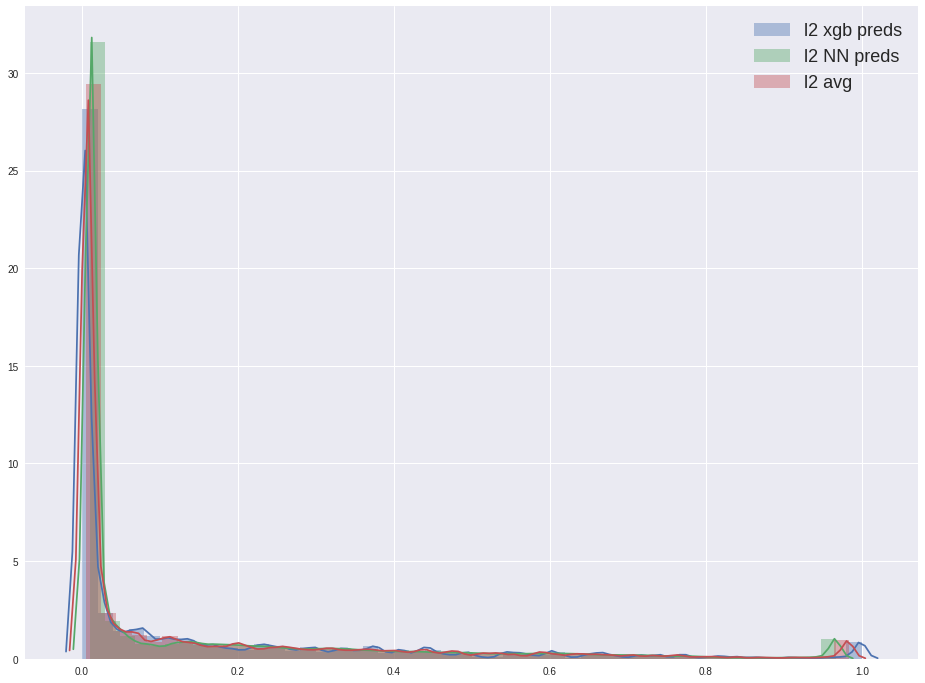

In [41]:
sns.distplot(xgb_stacked_preds_raw,label='l2 xgb preds'),
sns.distplot(NN_stacked_preds_raw,label='l2 NN preds'),
sns.distplot(final_l2_avg_raw,label='l2 avg')

plt.legend(loc='upper right', prop={'size': 18})


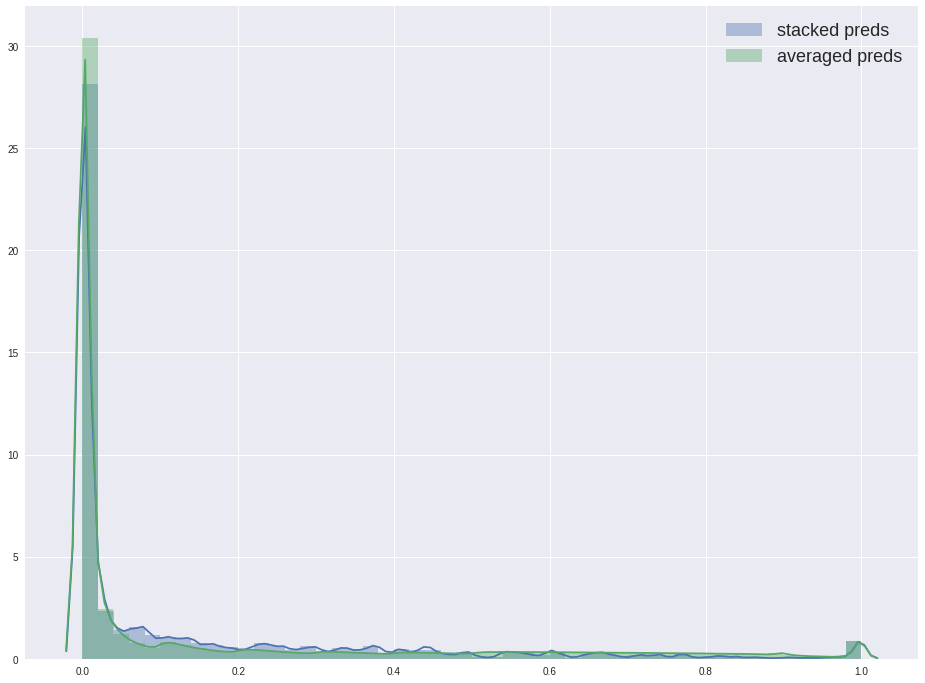

In [46]:
sns.distplot(xgb_stacked_preds_raw,label='stacked preds'),sns.distplot((xgb_test_preds+NN_test_preds)/2.,label='averaged preds')
plt.legend(loc='upper right', prop={'size': 18})


In [36]:
link_function(final_l2_avg_raw)

array([[ 0.00184083],
       [ 0.09933883],
       [ 0.17781933],
       ..., 
       [ 0.00184482],
       [ 0.07020938],
       [ 0.08826888]])

In [39]:
np.mean([l2_xgb__fixed,l2_NN_fixed],axis=0)

array([[ 0.00184673],
       [ 0.09936055],
       [ 0.17796456],
       ..., 
       [ 0.00185075],
       [ 0.07020971],
       [ 0.08827162]])

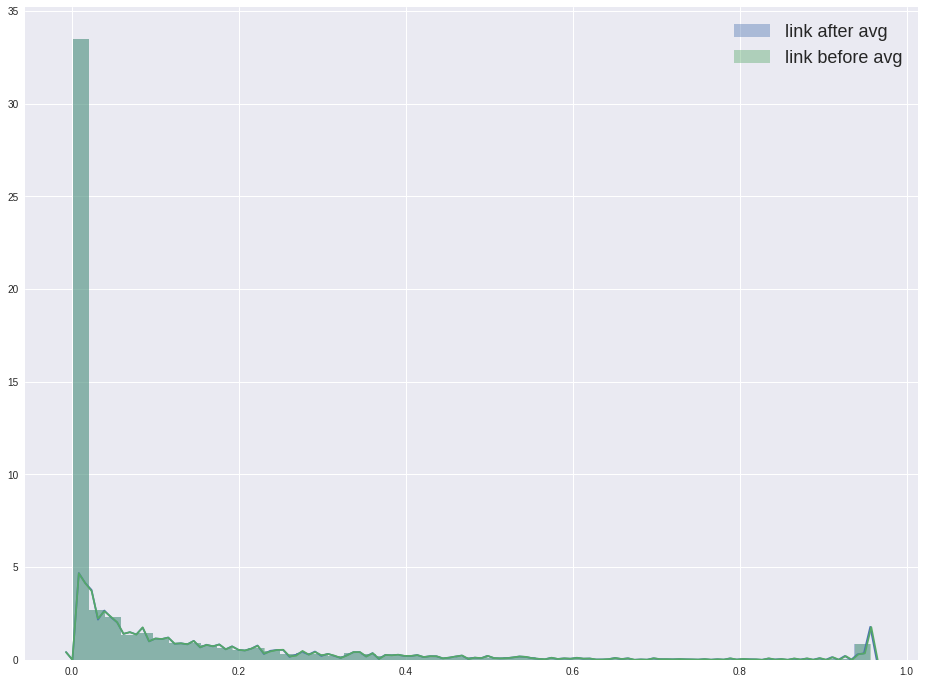

In [35]:
#mean before or after link_function
sns.distplot(link_function(final_l2_avg_raw),label='link after avg'),
sns.distplot(np.mean([l2_xgb__fixed,l2_NN_fixed],axis=0),label='link before avg')
plt.legend(loc='upper right', prop={'size': 18})
